# Flux Vector Splitting

The flux vector splitting (FVS) method is a means of solving a hyperbolic system of equations in an upwind fashion. In this note, we will establish an implementation framework for computing the flux at a face using FVS.

## Preamble

* Define "vec" command for LaTeX $\newcommand{vec}[1]{\boldsymbol{#1}}$

In [2]:
import sympy
sympy.init_printing(use_unicode=True)

## Conservation Equations
Consider the Euler Equations in 3D: 

\begin{equation}
    \partial_t \vec{w} + \partial_i \vec{f}_i = 0
\end{equation}

Where

\begin{equation}
    \vec{w} = \begin{bmatrix} 
        \rho     \\ 
        \rho u_1 \\ 
        \rho u_2 \\ 
        \rho u_3 \\ 
        \rho E 
    \end{bmatrix}
    \qquad
    \vec{f}_i = \begin{bmatrix}
        \rho u_i                    \\ 
        \rho u_1 u_i + \delta_{1i}p \\ 
        \rho u_2 u_i + \delta_{2i}p \\ 
        \rho u_3 u_i + \delta_{3i}p \\ 
        \rho H u_i
    \end{bmatrix}
\end{equation}

With the constituitive relations

\begin{align}
    p &= \rho R T
       = \left( \gamma - 1 \right) \rho e \\
    e &= c_vT = E - k \\
    k &= \frac{1}{2}u_i u_i \\
    H &= E + \frac{p}{\rho} \\
\end{align}


## Flux Jacobians

Many computational methods require linearization of the flux vectors, which can be defined for a generalized coordinate direction $\vec{n} = [n_1, n_2, n_3]$ as follows: 

\begin{equation}
    \vec{A}_n = \partial_\vec{w} \vec{f}_i n_i 
        = \partial_\vec{w} \begin{bmatrix}
            \rho u_i n_i             \\ 
            \rho u_1 u_i n_i + n_1 p \\ 
            \rho u_2 u_i n_i + n_2 p \\ 
            \rho u_3 u_i n_i + n_3 p \\ 
            \rho H u_i n_i
        \end{bmatrix}
        = \partial_\vec{w} \left(\vec{w} u_i n_i \right) + \partial_\vec{w} p \begin{bmatrix}
            0   \\ 
            n_1 \\ 
            n_2 \\ 
            n_3 \\ 
            u_i n_i
        \end{bmatrix}
\end{equation}

Defining $u_n = u_i n_i$ and noting that $\partial_\vec{w} u_n = \rho^{-1} \cdot \left[ -u_n, n_1, n_2, n_3, 0 \right]$, the equation above becomes

\begin{equation}
    \vec{A}_n = \vec{I} u_n
    + \begin{bmatrix} 1 \\ u_1 \\ u_2 \\ u_3 \\ H \end{bmatrix} 
      \begin{bmatrix} -u_n, n_1, n_2, n_3, 0 \end{bmatrix}
    + \begin{bmatrix} 0 \\ n_1 \\ n_2 \\ n_3 \\ u_n \end{bmatrix} \partial_\vec{w} p
\end{equation}

Note that is deriving the formula, we have not yet invoked any assumptions about the thermochemical characteristics of the gas (ideal, calorically perfect, etc.). Furthermore, the expression can be implemented with reasonable efficiency since we're simply summing a diagonal plus two outer products.




If we assume the gas is in thermochemical equilibrium, the equation of state for the mixture can be written in the form $p = p(\rho,\rho e)$. Therefore, the partial derivative of pressure with respect to our state variables may be written as: 

\begin{equation}
    \partial_{\vec{w}}p = \left. \frac{\partial p}{\partial\rho}\right|_{\rho e} \partial_\vec{w} \rho
                        + \left. \frac{\partial p}{\partial\rho e}\right|_\rho \partial_\vec{w} \rho e
                        = \alpha \cdot \partial_\vec{w} \rho + \beta \cdot \partial_\vec{w} \rho e
\end{equation}

Recalling that $\rho e = \rho E - \rho k$, we have:

\begin{align}
    \partial_\vec{w} \rho   &= \begin{bmatrix} 1, &0,  &0,  &0,  &0 \end{bmatrix} \\
    \partial_\vec{w} \rho e &= \begin{bmatrix} k, &-u_1, &-u_2, &-u_3, &1 \end{bmatrix} \\
    \partial_\vec{w} p      &= \beta \begin{bmatrix} k + \beta^{-1}\alpha, &-u_1, &-u_2, &-u_3, &1 \end{bmatrix}
\end{align}

Substituting this into our previous expression for $\vec{A}_n$:

\begin{equation}
    \vec{A}_n = \vec{I} u_n
    + \begin{bmatrix} 1 \\ u_1 \\ u_2 \\ u_3 \\ H \end{bmatrix} 
      \begin{bmatrix} -u_n, n_1, n_2, n_3, 0 \end{bmatrix}
    + \beta
      \begin{bmatrix} 0 \\ n_1 \\ n_2 \\ n_3 \\ u_n \end{bmatrix} 
      \begin{bmatrix} k + \beta^{-1}\alpha, -u_1, -u_2, -u_3, 1 \end{bmatrix}
\end{equation}

In practice, it may not be possible to parameterize the equation of state in terms of $\rho, \rho e$. For example, the equilibrium air curve fits of Reference [1] utilize an equation of state of the form 

\begin{equation}
    p = \rho e \cdot \left( \gamma \left( \ln{\rho}, \ln{e} \right) - 1 \right)
\end{equation}

With this form, it is simpler to compute partial derivatives with respect to $\rho, e$: 

\begin{align}
    \left.\frac{\partial p}{\partial \rho}\right|_{e} &= e\left( \gamma-1 + \frac{\partial \gamma}{\partial \ln{\rho}}\right) \\
    \left.\frac{\partial p}{\partial e}\right|_{\rho} &= \rho\left( \gamma-1 + \frac{\partial\gamma}{\partial \ln{e}}\right)
\end{align}

This can then be related to $\alpha, \beta$ by expanding $\delta \rho e$ in the expression for the differential change in pressure:

\begin{align}
    \delta p &= \alpha \cdot \delta\rho + \beta \cdot \delta\rho e \\  
             &= \alpha \cdot \delta\rho + \beta \cdot \left( e \delta\rho + \rho \delta e \right) \\
             &= \left(\alpha + e\beta \right) \cdot \delta\rho + \rho \beta \cdot \delta e \\ 
\end{align}

From which we can surmize that

\begin{align}
    \beta  &= \frac{1}{\rho}\left. \frac{ \partial p }{ \partial e } \right|_\rho \\
    \alpha &= \left. \frac{ \partial p }{ \partial \rho } \right|_e - e\beta \\
\end{align}




For the case of an ideal, calorically perfect gas governed by the constituitive relations shown above, the partial derivatives of the equation of state are $\left(\alpha,\beta\right) = \left(0, \gamma-1\right)$. As a result, 

\begin{equation} 
    \partial_\vec{w}p = \left( \gamma - 1 \right) \cdot \left[ k, -u_1, -u_2, -u_3, 1 \right]
\end{equation}

Which leads to the following general expression for the flux Jacobian for the calorically perfect Euler equations:

\begin{equation}
    \vec{A}_n = \vec{I} u_n
    + \begin{bmatrix} 1 \\ u_1 \\ u_2 \\ u_3 \\ H \end{bmatrix} 
      \begin{bmatrix} -u_n, n_1, n_2, n_3, 0 \end{bmatrix}
    + \left(\gamma - 1\right)
      \begin{bmatrix} 0 \\ n_1 \\ n_2 \\ n_3 \\ u_n \end{bmatrix} 
      \begin{bmatrix} k, -u_1, -u_2, -u_3, 1 \end{bmatrix}
\end{equation}

The code below computes the calorically perfect Jacobian for $\vec{n} = [1, 0, 0]$, which I have verified matches the Jacobian published in Reference [2].

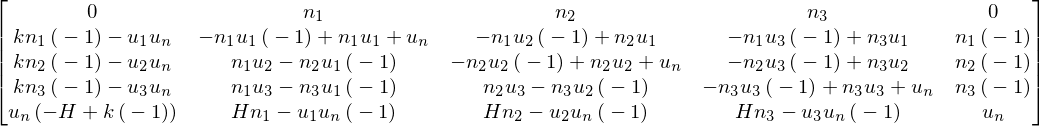

In [34]:
from sympy.matrices import Matrix, eye

# Symbols
u1, u2, u3 = sympy.symbols('u_1 u_2 u_3')
n1, n2, n3 = sympy.symbols('n_1 n_2 n_3')
H, e, k, γ = sympy.symbols('H e k γ')
un = sympy.symbols('u_n')

# General Jacobian matrix
v1 = Matrix([  1,  u1,  u2,  u3,   H])
v2 = Matrix([-un,  n1,  n2,  n3,   0])
v3 = Matrix([  0,  n1,  n2,  n3,  un])
v4 = (γ-1)*Matrix([k, -u1, -u2, -u3, 1])
An = un*eye(5) + v1*v2.transpose() + v3*v4.transpose()
An.simplify()
An

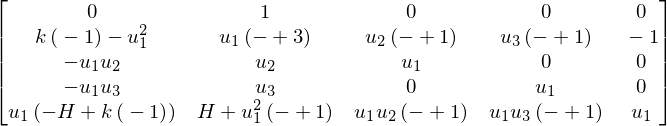

In [37]:
# Assume n = (1,0,0)
a = sympy.symbols('a')
A = An.subs({n1:1, n2:0, n3:0, un:u1})
A = A.expand()
for i,entry in enumerate(A):
    A[i] = sympy.collect(A[i], u1)
    A[i] = sympy.collect(A[i], u2)
    A[i] = sympy.collect(A[i], u3)
    A[i] = sympy.collect(A[i], k)
#A.simplify()
A # Matches Ref [1], Eq 2.15 

## Eigen-Structure
For many numerical schemes it is necessary to diagonalize the flux Jacobian.

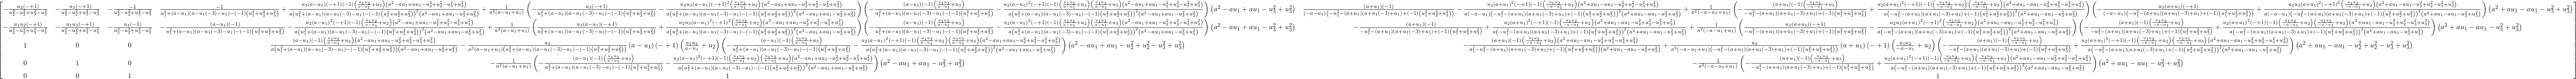

In [15]:
A = A.subs(k, u1*u1 + u2*u2 + u3*u3)
L,Λ = A.diagonalize()
L

## References

1. S. Srinivasan, J. Tannehill, K. Weilmuenster. "Simplified Curve Fits for the Thermodynamic Properties of Equilibrium Air". NASA Reference Publication 1181. August 1987.